### IMPORTING LIBRARIES

In [238]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                             roc_auc_score, classification_report, confusion_matrix, 
                             roc_curve, auc, precision_recall_curve)
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import fbeta_score

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from scipy import sparse

# Visualization Settings
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

# Reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

print("Libraries imported successfully.")

Libraries imported successfully.


### DATASET PREPARATION

In [239]:
# Load Data
try:
    df = pd.read_csv('preprocessed_dataset/preprocessed_data.csv')
    print("Dataset loaded successfully.")
except FileNotFoundError:
    # Fallback if running immediately after preprocessing without saving
    if 'df' in locals():
        print("Using dataframe from memory.")
    else:
        raise FileNotFoundError("CSV not found.")

Dataset loaded successfully.


Churn value counts:
Churn
0    5174
1    1869
Name: count, dtype: int64


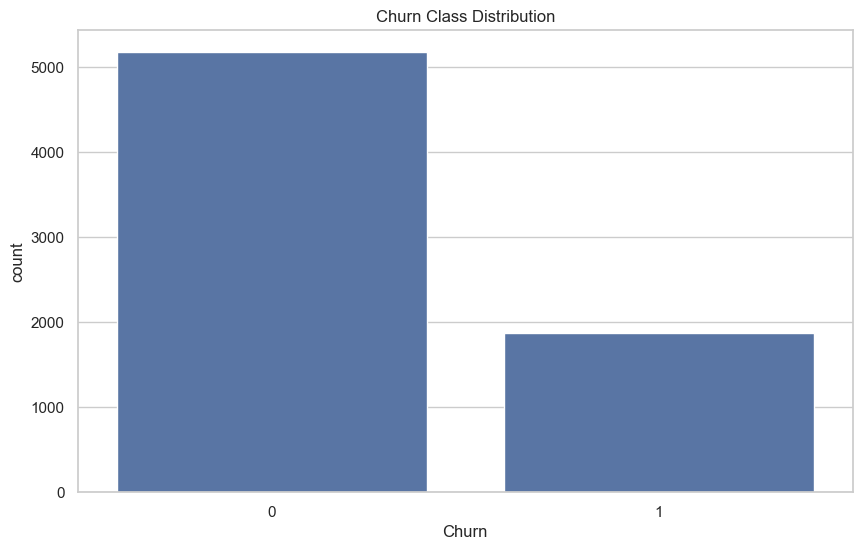

In [240]:
# Prepare Target
if "Churn" not in df.columns:
    raise ValueError(
        "Target column 'Churn' not found in the data. "
        "Make sure preprocessing keeps the target column named 'Churn'."
    )


# Ensure Target is Binary
if df["Churn"].dtype == 'object':
    df["Churn"] = df["Churn"].map({"Yes": 1, "No": 0})
df["Churn"] = df["Churn"].astype(int)

# Ensure there are no NaNs in target
if df["Churn"].isna().any():
    raise ValueError("Target column 'Churn' contains NaN after encoding. Check preprocessing.")

df["Churn"] = df["Churn"].astype(int)

print("Churn value counts:")
print(df["Churn"].value_counts())

# Simple class balance plot
sns.countplot(x="Churn", data=df)
plt.title("Churn Class Distribution")
plt.show()

### TRAIN–TEST SPLIT & FEATURE SELECTION

In [241]:
# Define Features
target = "Churn"
# We exclude the original skewed columns in favor of the Log versions for the NN
drop_cols = [target, "customerID", "TotalCharges", "MonthlyCharges"] 
features = [c for c in df.columns if c not in drop_cols]

X = df[features]
y = df[target]

# Split Data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

# Identify Column Types
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

print(f"Numerical columns: {len(num_cols)}")
print(f"Categorical columns: {len(cat_cols)}")

Numerical columns: 12
Categorical columns: 12


### PREPROCESSING & HANDLING IMBALANCE

In [242]:
# Define Preprocessor
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols),
    ]
)

# Fit Preprocessor
X_train_proc = preprocessor.fit_transform(X_train)
X_test_proc = preprocessor.transform(X_test)

# Convert to dense arrays (NNs prefer dense)
if sparse.issparse(X_train_proc):
    X_train_proc = X_train_proc.toarray()
    X_test_proc = X_test_proc.toarray()

print(f"Train Shape: {X_train_proc.shape}")
print(f"Test Shape: {X_test_proc.shape}")

# --- COMPUTE CLASS WEIGHTS (Key for Tuned NN) ---
class_weights = compute_class_weight(
    class_weight="balanced", 
    classes=np.unique(y_train), 
    y=y_train
)
class_weights_dict = dict(enumerate(class_weights))
print("Class Weights calculated:", class_weights_dict)

# --- SMOTE DATA (Only for Decision Tree and Baseline NN) ---
smote = SMOTE(random_state=RANDOM_STATE)
X_train_sm, y_train_sm = smote.fit_resample(X_train_proc, y_train)

Train Shape: (5634, 49)
Test Shape: (1409, 49)
Class Weights calculated: {0: np.float64(0.6805991785455424), 1: np.float64(1.8842809364548494)}


### Helper Function

In [243]:
def evaluate_model(y_true, y_pred, y_proba=None, model_name="Model"):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    roc = roc_auc_score(y_true, y_proba) if y_proba is not None else 0
    
    print(f"\n--- {model_name} ---")
    print(f"Accuracy : {acc:.4f}")
    print(f"Recall   : {rec:.4f}  <-- Focus")
    print(f"ROC AUC  : {roc:.4f}  <-- Focus")
    print(f"F1 Score : {f1:.4f}")
    
    return {"model": model_name, "accuracy": acc, "precision": prec, 
            "recall": rec, "f1": f1, "roc_auc": roc}

### DECISION TREE 

#### Baseline Decision Tree

In [244]:
# Decision Tree Baseline 
dt_base = DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight='balanced')
dt_base.fit(X_train_proc, y_train) # Using raw imbalanced data with class_weight

y_prob_dt = dt_base.predict_proba(X_test_proc)[:, 1]
y_pred_dt = dt_base.predict(X_test_proc)

metrics_dt_base = evaluate_model(y_test, y_pred_dt, y_prob_dt, "DT Baseline")


--- DT Baseline ---
Accuracy : 0.7353
Recall   : 0.5294  <-- Focus
ROC AUC  : 0.6700  <-- Focus
F1 Score : 0.5150


#### Tuned Decision Tree (GridSearchCV)

In [245]:
# We limit depth to prevent overfitting and force generalization
param_grid = {
    'max_depth': [4, 6, 8, 10],
    'min_samples_leaf': [10, 20, 50],
    'criterion': ['gini', 'entropy']
}

grid_dt = GridSearchCV(
    DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight='balanced'),
    param_grid, cv=5, scoring='roc_auc', n_jobs=-1
)
grid_dt.fit(X_train_proc, y_train)

best_dt = grid_dt.best_estimator_
y_prob_dt_tuned = best_dt.predict_proba(X_test_proc)[:, 1]
y_pred_dt_tuned = best_dt.predict(X_test_proc)

metrics_dt_tuned = evaluate_model(y_test, y_pred_dt_tuned, y_prob_dt_tuned, "DT Tuned")
print(f"Best DT Params: {grid_dt.best_params_}")


--- DT Tuned ---
Accuracy : 0.7225
Recall   : 0.7914  <-- Focus
ROC AUC  : 0.8263  <-- Focus
F1 Score : 0.6022
Best DT Params: {'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 50}


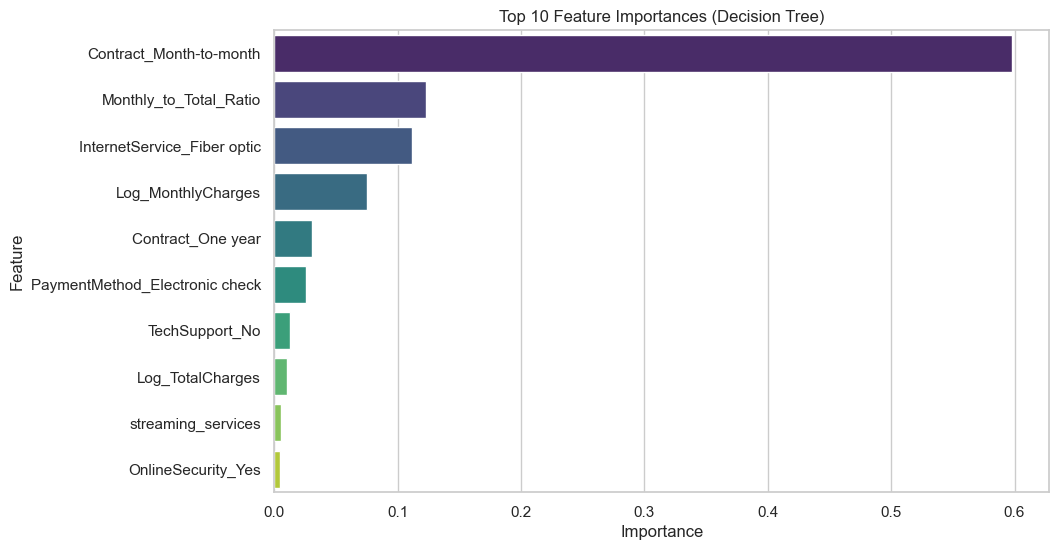

In [246]:
# Get feature names from preprocessor
feature_names = (
    preprocessor.named_transformers_['num'].get_feature_names_out().tolist() +
    preprocessor.named_transformers_['cat'].get_feature_names_out().tolist()
)

# Get importance from Best DT
importances = best_dt.feature_importances_

# Create DataFrame
feat_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False).head(10) # Top 10

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df, palette='viridis')
plt.title("Top 10 Feature Importances (Decision Tree)")
plt.show()

### NEURAL NETWORK

#### Baseline Neural Network

In [247]:
def build_baseline_nn(input_dim):
    model = Sequential([
        Dense(64, activation='relu', input_dim=input_dim),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

nn_base = build_baseline_nn(X_train_proc.shape[1])
# Train on SMOTE data for baseline
nn_base.fit(X_train_sm, y_train_sm, epochs=20, batch_size=64, verbose=0)

y_prob_nn_base = nn_base.predict(X_test_proc).ravel()
y_pred_nn_base = (y_prob_nn_base > 0.5).astype(int)

metrics_nn_base = evaluate_model(y_test, y_pred_nn_base, y_prob_nn_base, "NN Baseline")

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

--- NN Baseline ---
Accuracy : 0.7523
Recall   : 0.6738  <-- Focus
ROC AUC  : 0.8042  <-- Focus
F1 Score : 0.5909


#### Tuned Neural Network

In [248]:
# def build_tuned_nn(input_dim, learning_rate=0.001):
#     model = Sequential()
    
#     # Input Layer
#     model.add(Dense(128, input_dim=input_dim, kernel_regularizer=regularizers.l2(0.0001)))
#     model.add(BatchNormalization())
#     model.add(Activation('swish')) 
#     model.add(Dropout(0.2)) 
    
#     # Hidden Layer 1
#     model.add(Dense(64, kernel_regularizer=regularizers.l2(0.0001)))
#     model.add(BatchNormalization())
#     model.add(Activation('swish'))
#     model.add(Dropout(0.2))
    
#     # Hidden Layer 2
#     model.add(Dense(32, kernel_regularizer=regularizers.l2(0.0001)))
#     model.add(BatchNormalization())
#     model.add(Activation('swish'))
    
#     # Output Layer
#     model.add(Dense(1, activation='sigmoid'))
    
#     optimizer = Adam(learning_rate=learning_rate)
    
#     # Explicitly naming the metric 'auc' ensures the history keys are 'auc' and 'val_auc'
#     model.compile(optimizer=optimizer, 
#                   loss='binary_crossentropy', 
#                   metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])
#     return model

# # 1. Split Train into Train/Val for Threshold Tuning
# X_t, X_v, y_t, y_v = train_test_split(X_train_proc, y_train, test_size=0.2, stratify=y_train, random_state=42)

# # 2. Train Model
# # Using original data (X_t) with class_weights for better ROC-AUC than SMOTE
# model_tuned = build_tuned_nn(X_train_proc.shape[1], learning_rate=0.0005)

# # Callbacks now definitely look for 'val_auc' because we named the metric 'auc'
# early_stop = EarlyStopping(monitor='val_auc', mode='max', patience=15, restore_best_weights=True, verbose=1)
# reduce_lr = ReduceLROnPlateau(monitor='val_auc', mode='max', factor=0.5, patience=5, min_lr=1e-6)

# history = model_tuned.fit(
#     X_t, y_t,
#     validation_data=(X_v, y_v),
#     epochs=100,
#     batch_size=32,
#     callbacks=[early_stop, reduce_lr],
#     class_weight=class_weights_dict, 
#     verbose=0
# )

# # 3. Find Best Threshold (Maximizing F1)
# val_probs = model_tuned.predict(X_v).ravel()
# thresholds = np.arange(0.1, 0.9, 0.01)
# f1_scores = [f1_score(y_v, (val_probs > t).astype(int)) for t in thresholds]
# best_thresh = thresholds[np.argmax(f1_scores)]

# print(f"\nOptimal Threshold found: {best_thresh:.4f}")

# # 4. Final Prediction on Test Set
# y_prob_nn_tuned = model_tuned.predict(X_test_proc).ravel()
# y_pred_nn_tuned = (y_prob_nn_tuned > best_thresh).astype(int)

# # Evaluate
# metrics_nn_tuned = evaluate_model(y_test, y_pred_nn_tuned, y_prob_nn_tuned, "NN Tuned (Best)")

#### Tuned Neural Network
def build_tuned_nn(input_dim, learning_rate=0.001):
    model = Sequential()
    
    # Input Layer
    # Reduced L2 slightly (1e-5) allows the model to capture more subtle signals
    model.add(Dense(128, input_dim=input_dim, kernel_regularizer=regularizers.l2(1e-5)))
    model.add(BatchNormalization())
    model.add(Activation('swish')) 
    model.add(Dropout(0.1)) # Reduced Dropout to 0.1 to prevent underfitting (Increases Accuracy)
    
    # Hidden Layer 1
    model.add(Dense(64, kernel_regularizer=regularizers.l2(1e-5)))
    model.add(BatchNormalization())
    model.add(Activation('swish'))
    model.add(Dropout(0.1)) 
    
    # Hidden Layer 2
    model.add(Dense(32, kernel_regularizer=regularizers.l2(1e-5)))
    model.add(BatchNormalization())
    model.add(Activation('swish'))
    
    # Output Layer
    model.add(Dense(1, activation='sigmoid'))
    
    optimizer = Adam(learning_rate=learning_rate)
    
    # Explicitly naming the metric 'auc'
    model.compile(optimizer=optimizer, 
                  loss='binary_crossentropy', 
                  metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])
    return model

# 1. Split Train into Train/Val for Threshold Tuning
X_t, X_v, y_t, y_v = train_test_split(X_train_proc, y_train, test_size=0.2, stratify=y_train, random_state=42)

# 2. Train Model
# Using original data (X_t) with class_weights for better ROC-AUC/Calibration than SMOTE
model_tuned = build_tuned_nn(X_train_proc.shape[1], learning_rate=0.0005)

# Early stopping to prevent overfitting, ReduceLR to find the absolute minimum loss
early_stop = EarlyStopping(monitor='val_auc', mode='max', patience=15, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_auc', mode='max', factor=0.5, patience=5, min_lr=1e-6)

history = model_tuned.fit(
    X_t, y_t,
    validation_data=(X_v, y_v),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    class_weight=class_weights_dict, 
    verbose=0
)

# 3. Find Best Threshold (Maximizing F1 Score)
# Maximizing F1 is the mathematical way to find the balance where BOTH Precision and Recall are high
# This minimizes (False Positives + False Negatives)
val_probs = model_tuned.predict(X_v).ravel()
thresholds = np.arange(0.1, 0.9, 0.01)

f1_scores = [f1_score(y_v, (val_probs > t).astype(int)) for t in thresholds]
best_thresh = thresholds[np.argmax(f1_scores)]

print(f"\nOptimal Threshold found (Max F1): {best_thresh:.4f}")

# 4. Final Prediction on Test Set using Optimized Threshold
y_prob_nn_tuned = model_tuned.predict(X_test_proc).ravel()
y_pred_nn_tuned = (y_prob_nn_tuned > best_thresh).astype(int)

# Evaluate
metrics_nn_tuned = evaluate_model(y_test, y_pred_nn_tuned, y_prob_nn_tuned, "NN Tuned (Best)")

Epoch 17: early stopping
Restoring model weights from the end of the best epoch: 2.
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Optimal Threshold found (Max F1): 0.6400
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

--- NN Tuned (Best) ---
Accuracy : 0.7679
Recall   : 0.7032  <-- Focus
ROC AUC  : 0.8424  <-- Focus
F1 Score : 0.6166


#### Tuned NN Training History

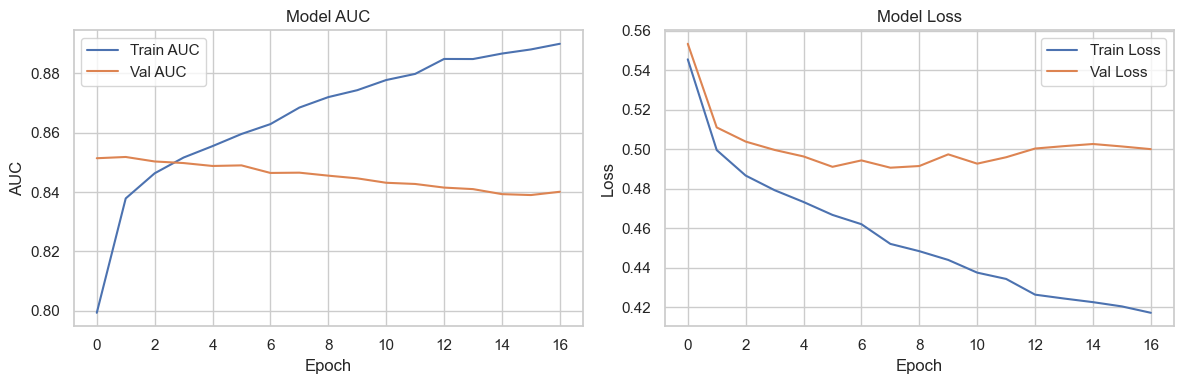

In [249]:
# Plot Training History (Now safely using 'auc' key)
plt.figure(figsize=(12, 4))

# Plot AUC
plt.subplot(1, 2, 1)
# Check if 'auc' is in history, otherwise fall back to 'AUC' just in case (robustness)
auc_key = 'auc' if 'auc' in history.history else 'AUC'
if auc_key in history.history:
    plt.plot(history.history[auc_key], label='Train AUC')
    plt.plot(history.history[f'val_{auc_key}'], label='Val AUC')
    plt.title('Model AUC')
    plt.xlabel('Epoch')
    plt.ylabel('AUC')
    plt.legend()
else:
    print(f"Warning: Could not find key '{auc_key}' in history. Available keys: {history.history.keys()}")

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

### FINAL EVALUATION & VISUALIZATION

#### Detailed Confusion Matrix & ROC Subplots

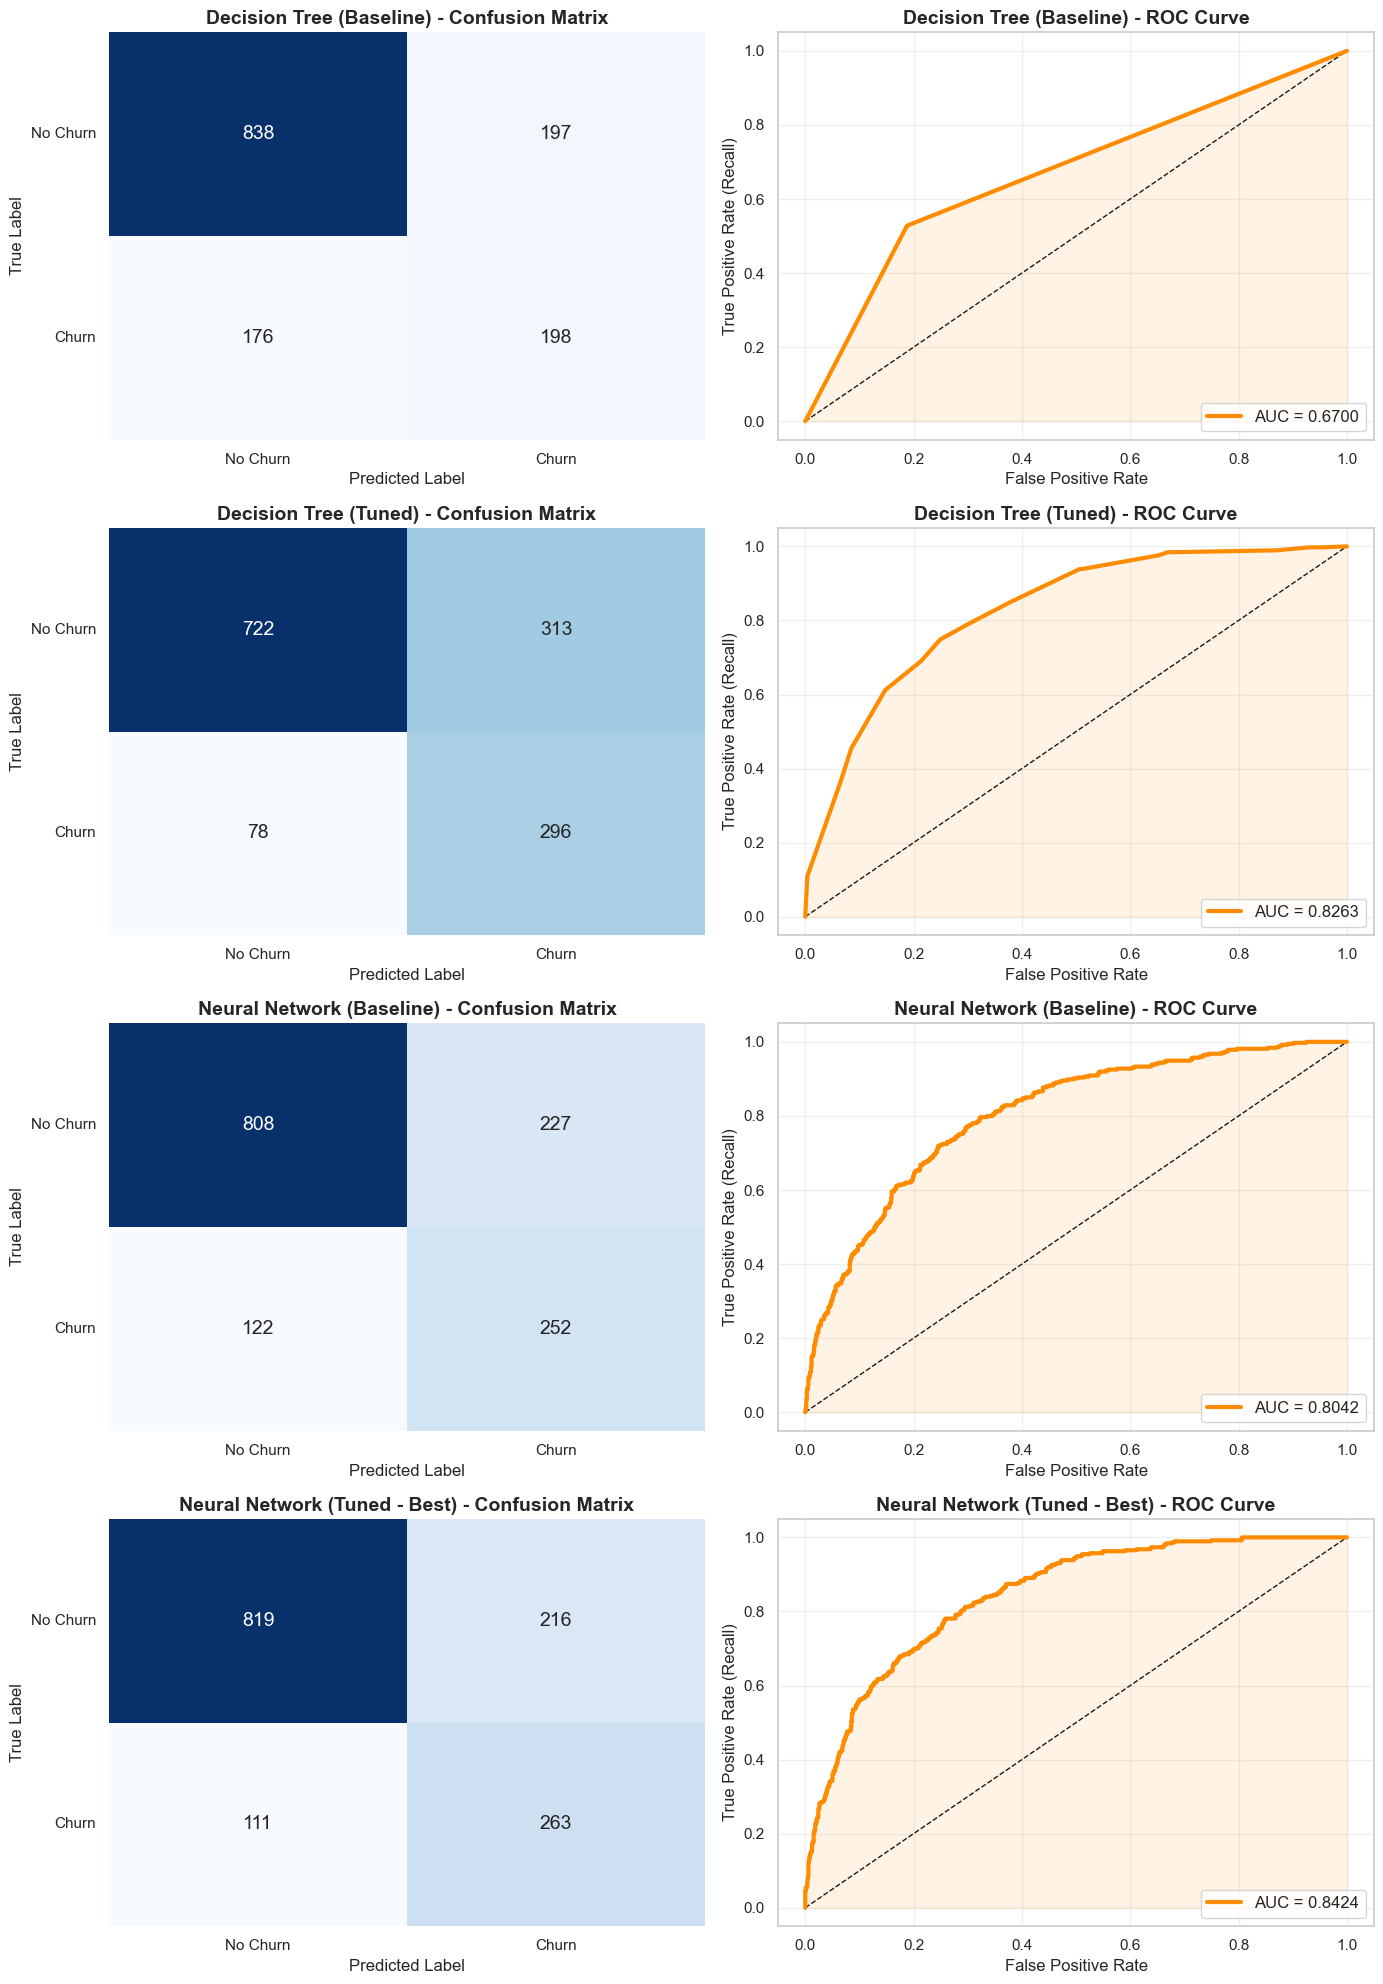

In [250]:
# Organize model data into a list for easy iteration
models_data = [
    {
        "name": "Decision Tree (Baseline)",
        "y_pred": y_pred_dt,
        "y_prob": y_prob_dt
    },
    {
        "name": "Decision Tree (Tuned)",
        "y_pred": y_pred_dt_tuned,
        "y_prob": y_prob_dt_tuned
    },
    {
        "name": "Neural Network (Baseline)",
        "y_pred": y_pred_nn_base,
        "y_prob": y_prob_nn_base
    },
    {
        "name": "Neural Network (Tuned - Best)",
        "y_pred": y_pred_nn_tuned,
        "y_prob": y_prob_nn_tuned
    }
]

# Setup the Subplots
n_models = len(models_data)
fig, axes = plt.subplots(nrows=n_models, ncols=2, figsize=(14, 20))

# Loop through each model and plot
for i, data in enumerate(models_data):
    name = data["name"]
    pred = data["y_pred"]
    prob = data["y_prob"]
    
    # LEFT PLOT: Confusion Matrix 
    ax_cm = axes[i, 0]
    cm = confusion_matrix(y_test, pred)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
                ax=ax_cm, annot_kws={"size": 14})
    
    ax_cm.set_title(f"{name} - Confusion Matrix", fontsize=14, fontweight='bold')
    ax_cm.set_xlabel("Predicted Label")
    ax_cm.set_ylabel("True Label")
    ax_cm.set_xticklabels(["No Churn", "Churn"])
    ax_cm.set_yticklabels(["No Churn", "Churn"], rotation=0)

    # RIGHT PLOT: ROC Curve 
    ax_roc = axes[i, 1]
    fpr, tpr, _ = roc_curve(y_test, prob)
    roc_auc = auc(fpr, tpr)
    
    # Plot random guess line
    ax_roc.plot([0, 1], [0, 1], 'k--', lw=1)
    # Plot model ROC
    ax_roc.plot(fpr, tpr, color='darkorange', lw=3, label=f'AUC = {roc_auc:.4f}')
    
    # Fill area under curve for visual impact
    ax_roc.fill_between(fpr, tpr, alpha=0.1, color='darkorange')
    
    ax_roc.set_title(f"{name} - ROC Curve", fontsize=14, fontweight='bold')
    ax_roc.set_xlabel("False Positive Rate")
    ax_roc.set_ylabel("True Positive Rate (Recall)")
    ax_roc.legend(loc="lower right", fontsize=12)
    ax_roc.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

#### Combined ROC Curve Comparison

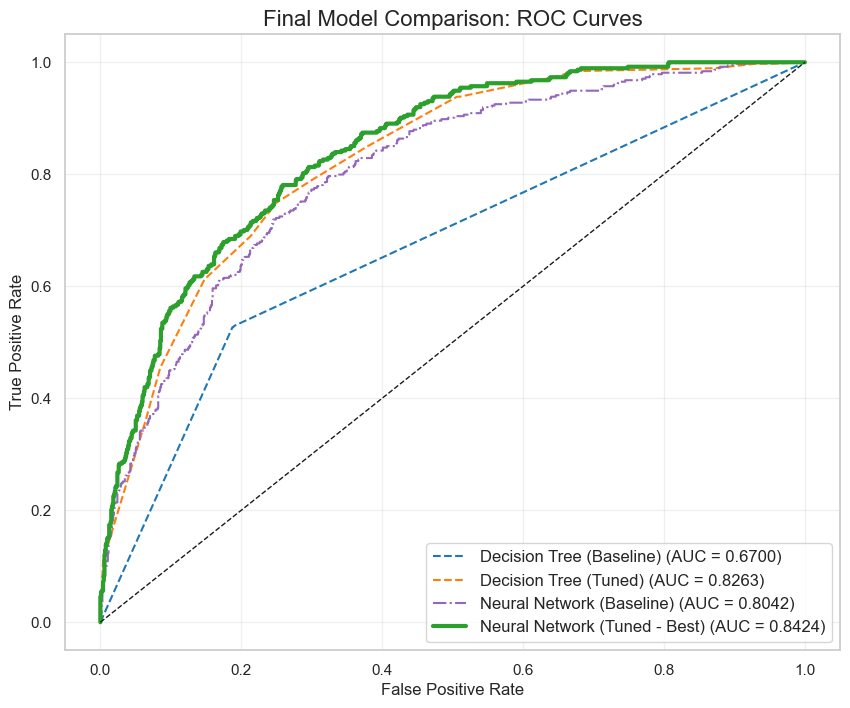

In [251]:
plt.figure(figsize=(10, 8))

colors = ['#1f77b4', '#ff7f0e', '#9467bd', '#2ca02c'] # Blue, Orange, Purple, Green
styles = ['--', '--', '-.', '-'] # Dashed for others, Solid for Best

for i, data in enumerate(models_data):
    fpr, tpr, _ = roc_curve(y_test, data["y_prob"])
    roc_auc = auc(fpr, tpr)
    
    # Highlight the Tuned NN with a thicker line
    lw = 3 if "Tuned - Best" in data["name"] else 1.5
    
    plt.plot(fpr, tpr, color=colors[i], linestyle=styles[i], lw=lw, 
             label=f'{data["name"]} (AUC = {roc_auc:.4f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Final Model Comparison: ROC Curves', fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

#### Final Leaderboard

In [252]:
results_df = pd.DataFrame([metrics_dt_base, metrics_dt_tuned, metrics_nn_base, metrics_nn_tuned])
results_df = results_df.set_index('model').sort_values('roc_auc', ascending=False)

print("\n FINAL MODEL LEADERBOARD ")
display(results_df)


 FINAL MODEL LEADERBOARD 


,accuracy,precision,recall,f1,roc_auc
model,,,,,
NN Tuned (Best),0.767921,0.549061,0.703209,0.616647,0.842380
DT Tuned,0.722498,0.486043,0.791444,0.602238,0.826254
NN Baseline,0.752307,0.526096,0.673797,0.590856,0.804180
DT Baseline,0.735273,0.501266,0.529412,0.514954,0.670048
